In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

In [2]:
# Dataset
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# split the data manually into 80% training, 10% testing, 10% validation
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

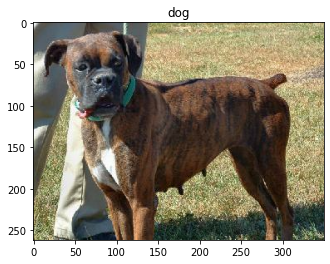

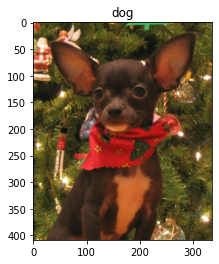

In [3]:
get_label_name = metadata.features['label'].int2str     # creates a function object that we can use to get labels

# display 2 images from the dataset
for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [4]:
# Data preprocessin (scaling different size image to same size)
IMG_SIZE = 160 # all will be resized to 160x160

def format_example(image, label):
    # returns a reshaped img
    image = tf.cast(image, tf.float32)  # convert all pixels to integers
    image = (image/127.5) - 1           # 1127.5 is exaclty half of 255 which is color value of pixel
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [5]:
# now we can apply this function to all our images using map
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

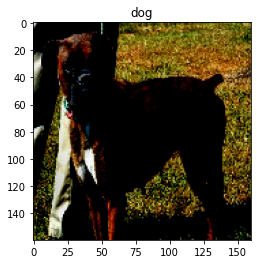

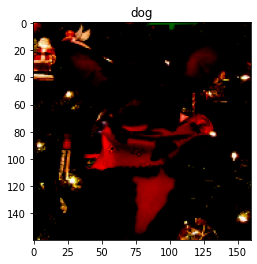

In [6]:
for image, label in train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [7]:
# shuffle and batch the images
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [8]:
# original shape vs. new shape
for img, label in raw_train.take(2):
    print("Original shape:", img.shape)

for img, label in train.take(2):
    print("New shape:", img.shape)

Original shape: (262, 350, 3)
Original shape: (409, 336, 3)
New shape: (160, 160, 3)
New shape: (160, 160, 3)


In [9]:
# Picking a pretrained model (in this case Google's MobileNet V2)
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,      # exclude the classifier from the model because we are using ours to ~ 
                                                weights='imagenet')     # ~ retrain some of the data for our specific cat-dog usecase

In [10]:
base_model.summary()
# output says (None, 5, 5, 1280) which means the model has 1280 layers that are 5x5

_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 10, 10, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 10, 10, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 10, 10, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 10, 10, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 10, 10, 64)   256         block_6_project[0][0]   

In [11]:
# here base_model will output a shape (32, 5, 5, 1280) tensor that is a feature extraction from our original (1, 160, 160, 3) image - 32 means we have 32 layers of different filters/features (we set our BATCH_SIZE to 32)
for image, _ in train_batches.take(1):
    pass

feature_batch = base_model(image)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [12]:
# Freezing the base (!) - we do this so the pretrained model doesn't retrain in our code
base_model.trainable = False

In [13]:
base_model.summary()

xpand_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 10, 10, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 10, 10, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 10, 10, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 10, 10, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 10, 10, 64)   256         block_6_project[0][

In [14]:
# Adding our classifier - Global pooling instead of Flatten (averages everything - explanation on google drive)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [15]:
# prediction layer with single dense neuron (we do this because we only have to predict either dog or cat)
prediction_layer = keras.layers.Dense(1, activation='sigmoid')      # sigmoid added for testing purposes, try other methods

In [16]:
# Combining all the layers
model = tf.keras.Sequential([
    base_model,             # pretrained model
    global_average_layer,   # our last hidden layer that averages everyhting from base model
    prediction_layer        # our output layer
])

In [17]:
model.summary()
# we will get 1281 trainable parameters, because we have a last dense layer with one node that connects to 1280 nodes in global average layer + 1 connection to the Bias node, hence 1281 parameters

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
# Training the model - global_average_layer and prediction_layer
base_learning_rate = 0.0001     # specifies the intensity of modifications to be made on network weights and biases (here is low)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),    # Binary because we are using 2 classes
              metrics=['accuracy'])

In [19]:
# We can evalute the model right now to see how it does before training it on our own new images
initial_epoch = 2
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)
# our accuracy is 52% now

C:\Python39\lib\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
20/20 [==============================] - 4s 67ms/step - loss: 0.7270 - accuracy: 0.5516


In [20]:
# now we train it on our own images
history = model.fit(train_batches,
                    epochs=initial_epoch,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/2
582/582 [==============================] - 61s 98ms/step - loss: 0.2089 - accuracy: 0.9314 - val_loss: 0.0883 - val_accuracy: 0.9746
Epoch 2/2
582/582 [==============================] - 56s 95ms/step - loss: 0.0729 - accuracy: 0.9772 - val_loss: 0.0642 - val_accuracy: 0.9785
[0.931434690952301, 0.9772165417671204]


In [21]:
# Save a model to your machine (because training can take even more that 1h) and load it as a new model in any code
model.save("dogs_vs_cats.h5")
new_model = tf.keras.models.load_model('dogs_vs_cats.h5')

C:\Python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [22]:
images = []
labels = []
for image, label in test.take(-1):
    images.append(image)
    labels.append(label)

In [23]:
# Testing the model

# a = 2
# predict = new_model.predict(np.array([images[a]]))
# print(predict)
# print(round(predict[0][0]))
# plt.figure()
# plt.imshow(images[a])
# plt.show()

In [24]:
CLASSES = ['Cat', 'Dog']

In [25]:
## Testing all the pictures

# def predict_single_image(model):
#     for i in range(len(images)):
#         image = images[i]
#         label = labels[i]
#         predict = model.predict(np.array([image]))
#         predicted_value = CLASSES[round(predict[0][0])]     # Not the finest solution I think
#         expected_value = CLASSES[label]
#         if expected_value != predicted_value:
#             print(predict)
#             show_image(image, expected_value, predicted_value)
#             break

# def show_image(image, expected_value, predicted_value):
#     plt.figure()
#     plt.imshow(image)
#     plt.title("Expected: " + expected_value)
#     plt.xlabel("Guessed: " + predicted_value)
#     plt.show()

# predict_single_image(new_model)

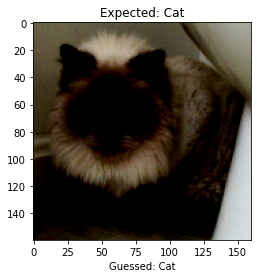

In [26]:
# Doing the predictions
def predict_single_image(model, image, image_label):
    predict = model.predict(np.array([image]))
    predicted_value = CLASSES[round(predict[0][0])]     # Not the finest solution I think
    expected_value = CLASSES[image_label]
    show_image(image, expected_value, predicted_value)

def get_number():
    while True:
        num = input("Enter number of picture: ")
        try:
            num = int(num)
            return num
        except:
            print('Gotta try again...')
            continue

def show_image(image, expected_value, predicted_value):
    plt.figure()
    plt.imshow(image)
    plt.title("Expected: " + expected_value)
    plt.xlabel("Guessed: " + predicted_value)
    plt.show()

a = get_number()
image = images[a]
label = labels[a]
predict_single_image(new_model, image, label)

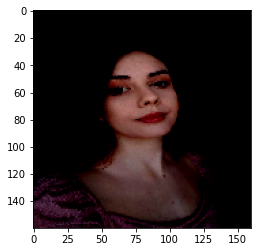

(160, 160, 3)


In [42]:
# load, transform and show local image for predicting purposes
from PIL import Image as PImage
img = PImage.open(r"C:\Users\Dzilaj Bilaj\Desktop\nino.jpg")

img = np.array(img)
img = tf.cast(img, tf.float32)  # convert all pixels to integers
img = (img/127.5) - 1           # 1127.5 is exaclty half of 255 which is color value of pixel
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

plt.figure()
plt.imshow(img)
plt.show()
print(img.shape)

[[0.71024686]]


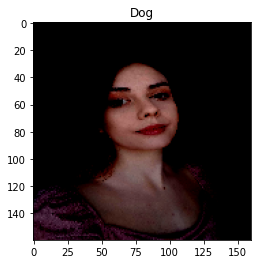

In [44]:
# predict local image
def predict_single_image(model, image):
    predict = model.predict(np.array([image]))
    print(predict)
    predicted_value = CLASSES[round(predict[0][0])]
    show_image(image, predicted_value)

def show_image(image, predicted_value):
    plt.figure()
    plt.imshow(image)
    plt.title(predicted_value)
    plt.show()

predict_single_image(new_model, img)